# Import Libraries and Data

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
path = '/Users/stephenhelvig/Documents/Python Projects/DataCo Analysis'

In [6]:
df = pd.read_pickle(os.path.join(path, 'Data', 'Prepared Data', 'dataco_cleaned_3.pkl'))

In [7]:
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['order_date_dateorders'].min()} to {df['order_date_dateorders'].max()}")
df.head()

Dataset shape: (180519, 65)
Date range: 2015-01-01 00:00:00 to 2018-01-31 23:38:00


,type,days_for_shipping_real,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,customer_country,customer_email,customer_fname,customer_id,customer_lname,customer_password,customer_segment,customer_state,customer_street,customer_zipcode,department_id,department_name,latitude_src,longitude_src,market,order_city,order_country,order_customer_id,order_date_dateorders,order_id,order_item_cardprod_id,order_item_discount,order_item_discount_rate,order_item_id,order_item_product_price,order_item_profit_ratio,order_item_quantity,sales,order_item_total,order_region,order_state,order_status,product_card_id,product_category_id,product_image,product_name,product_price,product_status,shipping_date_dateorders,shipping_mode,order_country_en,order_state_en,order_city_en,latitude_dest,longitude_dest,address_dest,shipping_distance_km,order_year,order_month,order_quarter,order_day_of_week,order_hour,order_month_name,order_day_name,department_corrected
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,Southeast Asia,Java Occidental,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-02-03 22:56:00,Standard Class,Indonesia,West Java,Bekasi,-6.238270,106.975573,"Bekasi, West Java, Indonesia",18479.364780,2018,1,1,2,22,January,Wednesday,Team Sports
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,South Asia,Rajastán,PENDING,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-18 12:27:00,Standard Class,India,Rajasthan,Bikaner,28.022935,73.311916,"Bikaner, Rajasthan, India",13259.724464,2018,1,1,5,12,January,Saturday,Team Sports
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,South Asia,Rajastán,CLOSED,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-17 12:06:00,Standard Class,India,Rajasthan,Bikaner,28.022935,73.311916,"Bikaner, Rajasthan, India",12581.292938,2018,1,1,5,12,January,Saturday,Team Sports
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,Oceania,Queensland,COMPLETE,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-16 11:45:00,Standard Class,Australia,Queensland,Townsville,-19.258964,146.816948,"Townsville City QLD 4810, Australia",11628.474178,2018,1,1,5,11,January,Saturday,Team Sports
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,Oceania,Queensland,PENDING_PAYMENT,1360,73,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-15 11:24:00,Standard Class,Australia,Queensland,Townsville,-19.258964,146.816948,"Townsville City QLD 4810, Australia",16559.192778,2018,

# Data Preparation for Time Series Analysis

In [8]:
# Examine date distribution
print("Date range analysis:")
print(f"First order: {df['order_date_dateorders'].min()}")
print(f"Last order: {df['order_date_dateorders'].max()}")
print(f"Total days in dataset: {(df['order_date_dateorders'].max() - df['order_date_dateorders'].min()).days}")

# Check for missing dates
date_range = pd.date_range(start=df['order_date_dateorders'].min(), 
                          end=df['order_date_dateorders'].max(), 
                          freq='D')
actual_dates = df['order_date_dateorders'].dt.date.unique()
missing_dates = set(date_range.date) - set(actual_dates)
print(f"Missing dates: {len(missing_dates)}")

# Monthly order distribution
monthly_orders = df.groupby(df['order_date_dateorders'].dt.to_period('M')).size()
print("\nMonthly order counts:")
print(monthly_orders.head(10))
print("...")
print(monthly_orders.tail(10))

Date range analysis:
First order: 2015-01-01 00:00:00
Last order: 2018-01-31 23:38:00
Total days in dataset: 1126
Missing dates: 0

Monthly order counts:
order_date_dateorders
2015-01    5322
2015-02    4729
2015-03    5362
2015-04    5126
2015-05    5357
2015-06    5134
2015-07    5299
2015-08    5273
2015-09    5140
2015-10    5302
Freq: M, dtype: int64
...
order_date_dateorders
2017-04    5212
2017-05    5317
2017-06    4951
2017-07    5318
2017-08    5305
2017-09    5189
2017-10    2255
2017-11    2055
2017-12    2124
2018-01    2123
Freq: M, dtype: int64


In [9]:
# Create a subset: Use complete calendar years only
subset_df = df[(df['order_date_dateorders'].dt.year >= 2015) & 
               (df['order_date_dateorders'].dt.year <= 2017)].copy()

print(f"Original dataset: {df.shape[0]:,} orders")
print(f"Subset dataset: {subset_df.shape[0]:,} orders")
print(f"Date range: {subset_df['order_date_dateorders'].min()} to {subset_df['order_date_dateorders'].max()}")

Original dataset: 180,519 orders
Subset dataset: 178,396 orders
Date range: 2015-01-01 00:00:00 to 2017-12-31 23:52:00


### Subset Logic Explanation:
I'm focusing on 2015-2017 complete years to avoid partial year effects and ensure clean seasonal pattern detection.

In [14]:
# Create time series aggregations

# Daily aggregations
daily_metrics = subset_df.groupby(subset_df['order_date_dateorders'].dt.date).agg({
    'order_id': 'count',                    # Daily order count
    'sales': 'sum',                         # Daily gross revenue (before discounts)
    'order_item_total': 'sum',              # Daily net revenue (after discounts)
    'benefit_per_order': 'sum',             # Daily total profit
    'order_item_discount': 'sum'            # Daily total discounts given
}).rename(columns={
    'order_id': 'daily_orders',
    'sales': 'daily_gross_revenue',
    'order_item_total': 'daily_net_revenue', 
    'benefit_per_order': 'daily_profit',
    'order_item_discount': 'daily_discounts'
})

# Calculate derived metrics
daily_metrics['avg_order_value'] = daily_metrics['daily_net_revenue'] / daily_metrics['daily_orders']
daily_metrics['avg_profit_per_order'] = daily_metrics['daily_profit'] / daily_metrics['daily_orders']
daily_metrics['discount_rate'] = daily_metrics['daily_discounts'] / daily_metrics['daily_gross_revenue']

# Convert date index back to datetime for time series analysis
daily_metrics.index = pd.to_datetime(daily_metrics.index)
daily_metrics.index.name = 'order_date_dateorders'

print("Daily metrics time series created:")
print(daily_metrics.head())
print(f"\nTime series shape: {daily_metrics.shape}")
print(f"Date range: {daily_metrics.index.min()} to {daily_metrics.index.max()}")
print(f"\nMetrics overview:")
print(f"Average daily orders: {daily_metrics['daily_orders'].mean():.1f}")
print(f"Average daily net revenue: ${daily_metrics['daily_net_revenue'].mean():,.2f}")
print(f"Average order value: ${daily_metrics['avg_order_value'].mean():.2f}")
print(f"Average discount rate: {daily_metrics['discount_rate'].mean():.1%}")

Daily metrics time series created:
                       daily_orders  daily_gross_revenue  daily_net_revenue  \
order_date_dateorders                                                         
2015-01-01                      168         32806.090690       29379.700398   
2015-01-02                      154         29818.210575       26801.900242   
2015-01-03                      179         36348.710648       32859.300341   
2015-01-04                      191         35738.970669       31869.500330   
2015-01-05                      160         31067.910603       27533.050215   

                       daily_profit  daily_discounts  avg_order_value  \
order_date_dateorders                                                   
2015-01-01              4433.480025      3426.400004       174.879169   
2015-01-02              1292.849976      3016.359999       174.038313   
2015-01-03              5366.600017      3489.449987       183.571510   
2015-01-04              5630.989989      3869.

# Line Charts of Time Series Data

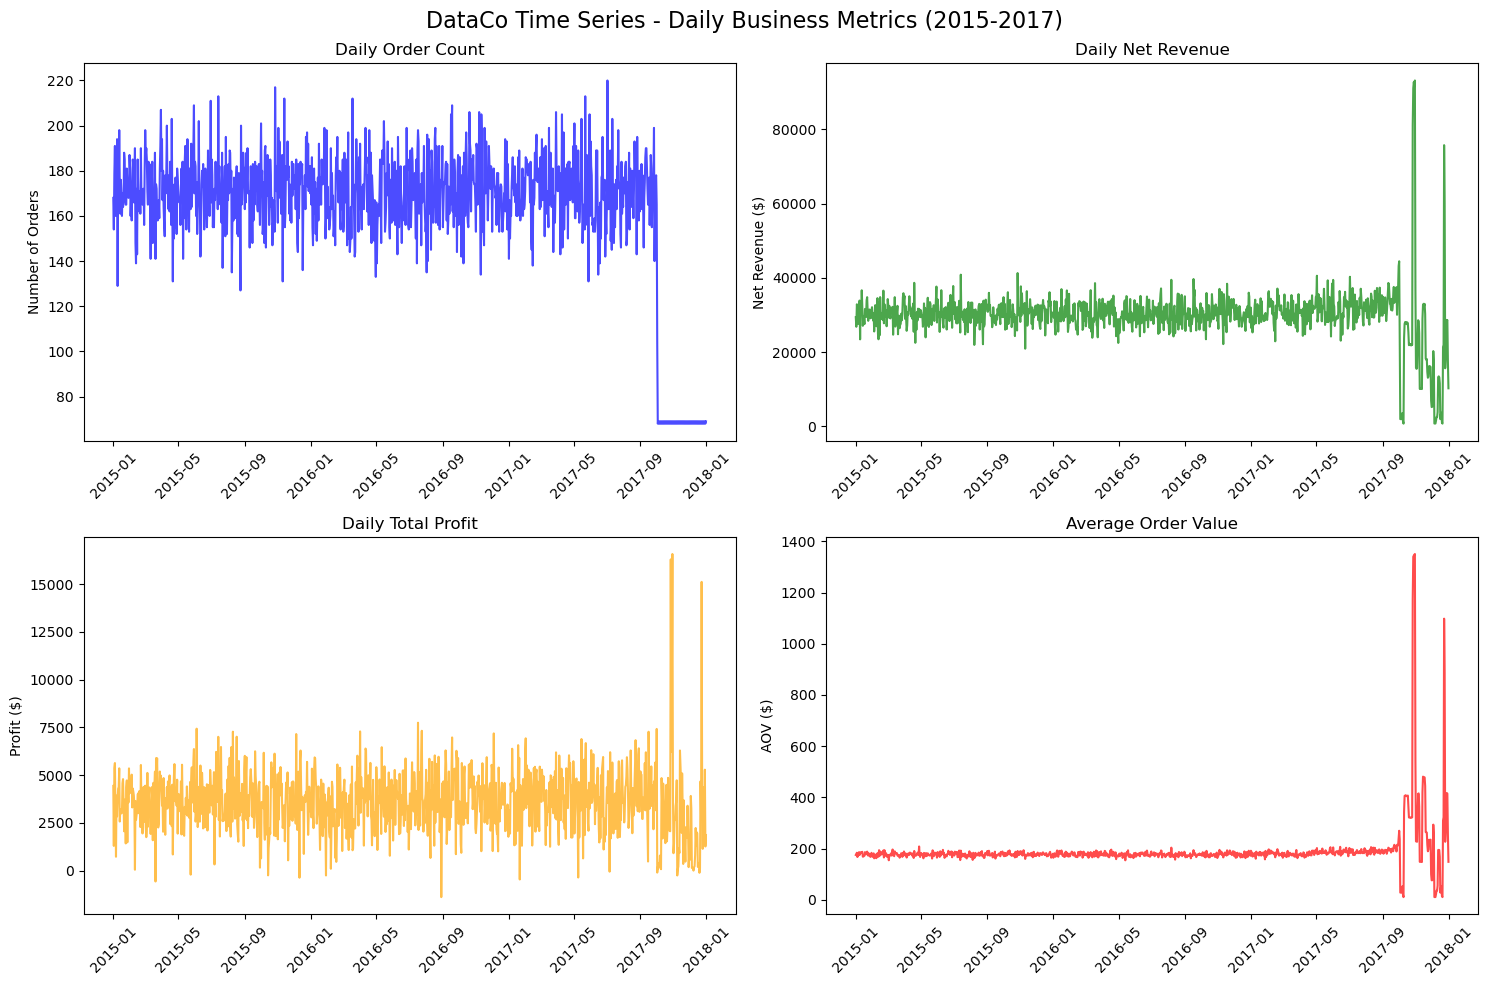

In [15]:
# Create comprehensive line charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DataCo Time Series - Daily Business Metrics (2015-2017)', fontsize=16)

# Daily orders
axes[0,0].plot(daily_metrics.index, daily_metrics['daily_orders'], color='blue', alpha=0.7)
axes[0,0].set_title('Daily Order Count')
axes[0,0].set_ylabel('Number of Orders')
axes[0,0].tick_params(axis='x', rotation=45)

# Daily net revenue (after discounts)
axes[0,1].plot(daily_metrics.index, daily_metrics['daily_net_revenue'], color='green', alpha=0.7)
axes[0,1].set_title('Daily Net Revenue')
axes[0,1].set_ylabel('Net Revenue ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Daily profit
axes[1,0].plot(daily_metrics.index, daily_metrics['daily_profit'], color='orange', alpha=0.7)
axes[1,0].set_title('Daily Total Profit')
axes[1,0].set_ylabel('Profit ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average order value
axes[1,1].plot(daily_metrics.index, daily_metrics['avg_order_value'], color='red', alpha=0.7)
axes[1,1].set_title('Average Order Value')
axes[1,1].set_ylabel('AOV ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Decomposition

In [17]:
# Select primary time series for analysis
primary_series = daily_metrics['daily_orders'].copy()

# Remove any missing values
primary_series = primary_series.dropna()

print(f"Primary time series: Daily Orders")
print(f"Length: {len(primary_series)} days")
print(f"Mean: {primary_series.mean():.2f} orders/day")
print(f"Std: {primary_series.std():.2f}")
print(f"Min: {primary_series.min()}, Max: {primary_series.max()}")

Primary time series: Daily Orders
Length: 1096 days
Mean: 162.77 orders/day
Std: 31.57
Min: 68, Max: 220


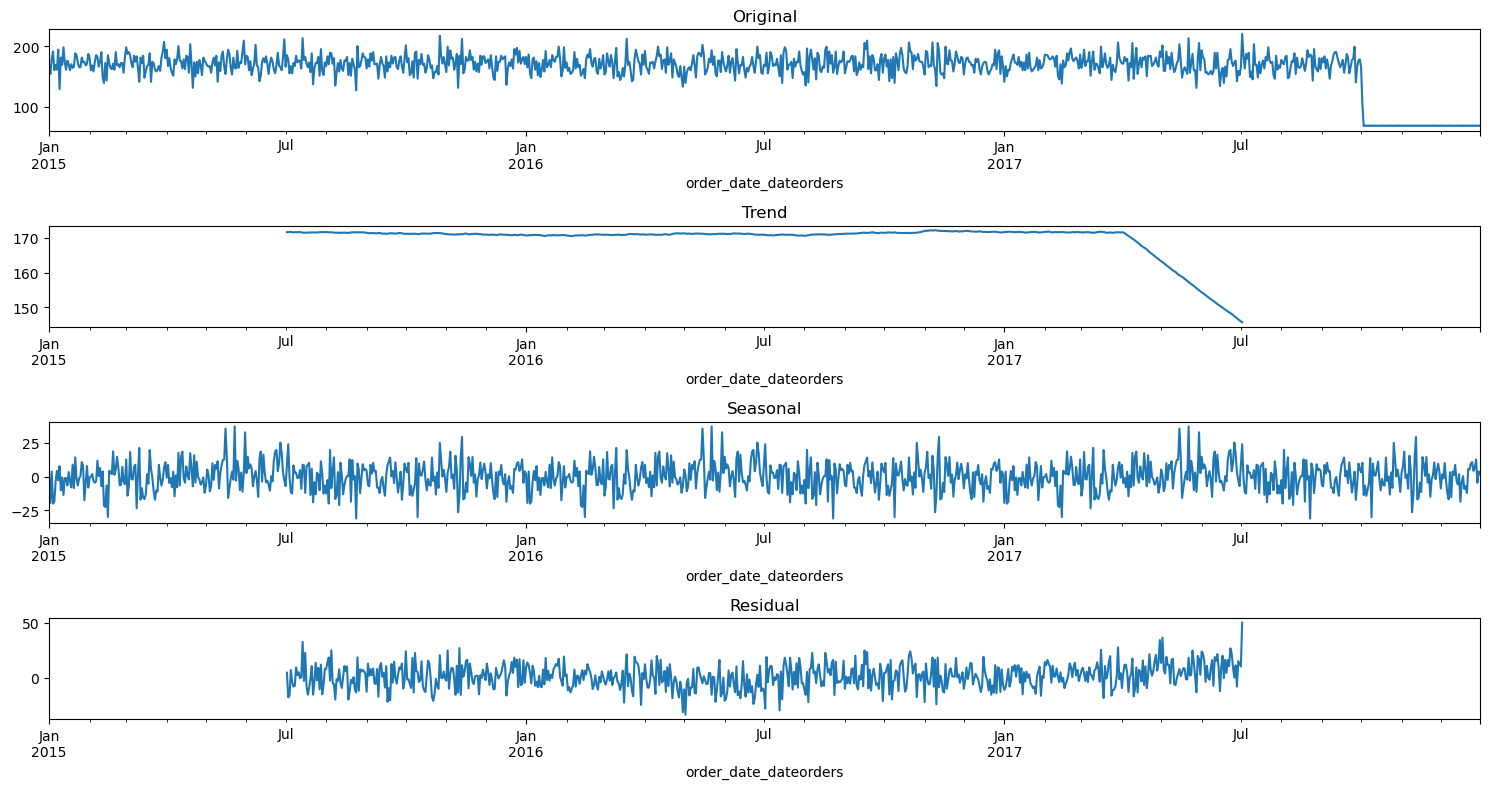

In [19]:
decomposition = seasonal_decompose(primary_series, model='additive', period=365)
fig, axes = plt.subplots(4, 1, figsize=(15, 8))
decomposition.observed.plot(ax=axes[0], title='Original')
decomposition.trend.plot(ax=axes[1], title='Trend') 
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

## Decomposition Results:

- **Trend**: Flat at ~170 until mid-2017, then sharp decline
- **Seasonal**: Shows some annual patterns
- **Residual**: Mostly random noise around 0

# Stationarity Testing (Dickey-Fuller Test)

In [22]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test to your primary series
dickey_fuller(primary_series)

Dickey-Fuller Stationarity test:
Test Statistic                   -0.662223
p-value                           0.856293
Number of Lags Used               9.000000
Number of Observations Used    1086.000000
Critical Value (1%)              -3.436386
Critical Value (5%)              -2.864205
Critical Value (10%)             -2.568189
dtype: float64


## Dickey-Fuller Test Results

- **Null Hypothesis**: There is a unit root (is non-stationary). If p-value < 0.05, reject hypothesis (series is stationary)
- p-value = 0.856 which means we cannot reject the hypthosis so the series is NON-STATIONARY (p > 0.05) Differencing is needed.

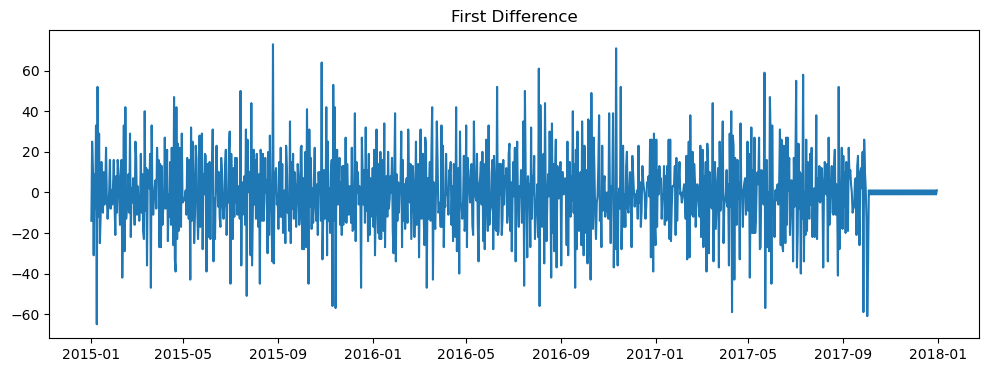


First Difference:
Dickey-Fuller Stationarity test:
Test Statistic                -1.843147e+01
p-value                        2.168239e-30
Number of Lags Used            8.000000e+00
Number of Observations Used    1.086000e+03
Critical Value (1%)           -3.436386e+00
Critical Value (5%)           -2.864205e+00
Critical Value (10%)          -2.568189e+00
dtype: float64


In [25]:
first_diff = primary_series.diff().dropna()
plt.figure(figsize=(12, 4))
plt.plot(first_diff)
plt.title('First Difference')
plt.show()

# Test first difference
print("\nFirst Difference:")
dickey_fuller(first_diff)

## First Difference Test Results

- **Test Statistic**: -18.43
- **p-value**: ≈ 0 (2.17e-30)
- **Interpretation**: p-value < 0.05, so we **reject H0**. The first difference series is **stationary** and ready for time series modeling.

# Autocorrelation Analysis

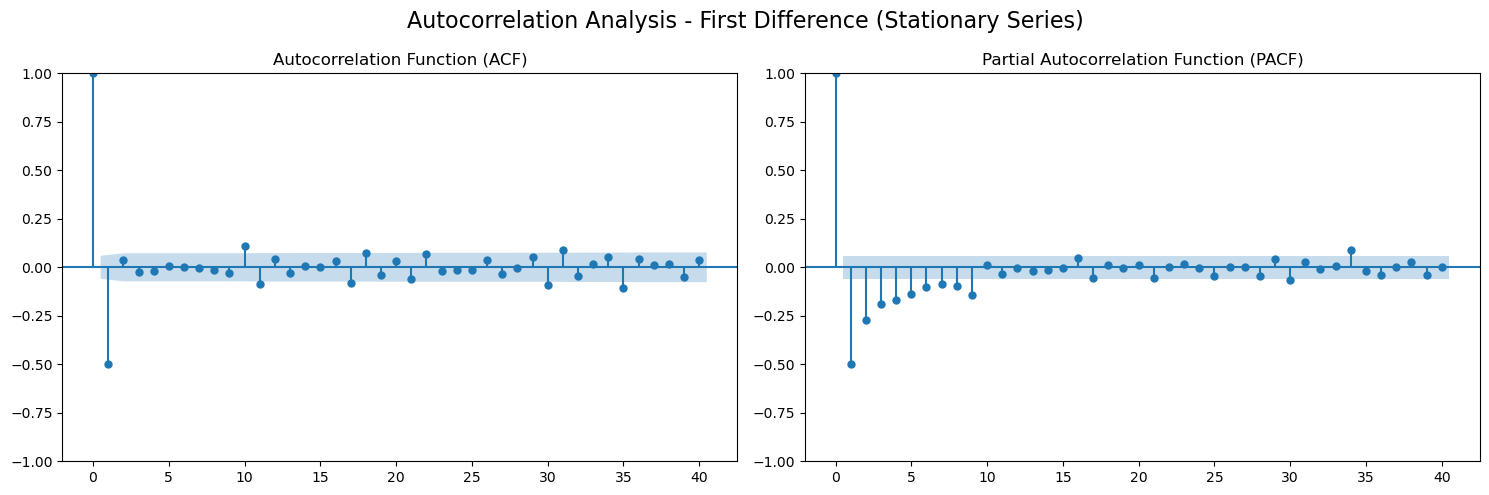

In [24]:
# Autocorrelation analysis using the stationary first difference series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Autocorrelation Analysis - First Difference (Stationary Series)', fontsize=16)

# Plot ACF and PACF
plot_acf(first_diff.dropna(), ax=axes[0], lags=40, title='Autocorrelation Function (ACF)')
plot_pacf(first_diff.dropna(), ax=axes[1], lags=40, title='Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()